In [1]:
import os
import re
import random
from collections import Counter
from datetime import datetime

import pandas as pd
from matplotlib import pyplot as plt, font_manager, rcParams

# Aksara font
FONT_PATH = "./fonts/Noto_Sans_Javanese/static/NotoSansJavanese-Regular.ttf"
font_manager.fontManager.addfont(FONT_PATH)
rcParams["font.family"] = font_manager.FontProperties(fname=FONT_PATH).get_name()


In [2]:
TOTAL_SAMPLE = 1000

DIR_PATH = f"./data/word_nglegena_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
RAW_CSV_PATH = f"{DIR_PATH}/raw_label.csv"
CSV_PATH = f"{DIR_PATH}/label.csv"

CONFIG = {
    "min_word": 2,
    "max_word": 6,
}

NGLEGENA = [
    ("ꦲ","ha"), ("ꦤ","na"), ("ꦕ","ca"), ("ꦫ","ra"), ("ꦏ","ka"),
    ("ꦢ","da"), ("ꦠ","ta"), ("ꦱ","sa"), ("ꦮ","wa"), ("ꦭ","la"),
    ("ꦥ","pa"), ("ꦝ","dha"), ("ꦗ","ja"), ("ꦪ","ya"), ("ꦚ","nya"),
    ("ꦩ","ma"), ("ꦒ","ga"), ("ꦧ","ba"), ("ꦛ","tha"), ("ꦔ","nga"),
]


In [3]:
def generate_word(cfg, coverage):
    lengths = list(range(cfg["min_word"], cfg["max_word"] + 1))
    len_weights = [
        1.0 / (coverage["word"][l] + 1.0)
        for l in lengths
    ]
    length = random.choices(lengths, weights=len_weights, k=1)[0]

    jawa, latin = "", ""

    for _ in range(length):
        # weighted aksara
        aks_weights = [
            1.0 / (coverage["aksara"][aks] + 1.0)
            for aks, _ in NGLEGENA
        ]
        aks, lat = random.choices(NGLEGENA, weights=aks_weights, k=1)[0]

        jawa += aks
        latin += lat
        coverage["aksara"][aks] += 1

    coverage["word"][length] += 1
    return jawa, latin, length



def generate_dataset(total, cfg, coverage):
    rows = []

    for i in range(total):
        jawa, latin, length = generate_word(cfg, coverage)
        rows.append({
            "image": f"img_{i:05d}.png",
            "transcription": jawa,
            "transliteration": latin,
            "length": length,
        })

    return pd.DataFrame(rows)



coverage = {
    "aksara": Counter({aks: 0 for aks, _ in NGLEGENA}),
    "word": Counter()
}
raw_df = generate_dataset(TOTAL_SAMPLE, CONFIG, coverage)
os.makedirs(os.path.dirname(RAW_CSV_PATH), exist_ok=True)
raw_df.to_csv(RAW_CSV_PATH, index=False)

In [4]:
ALLOWED_CHARS = set([aks for aks, _ in NGLEGENA])


# SCHEMA CHECK
required_cols = {"image", "transcription", "transliteration", "length"}
missing_cols = required_cols - set(raw_df.columns)

if missing_cols:
    raise ValueError(f"Kolom wajib hilang: {missing_cols}")
print("Skema kolom              : valid")


# NULL VALUE CHECK
null_rows = raw_df[raw_df.isnull().any(axis=1)]

print(f"Baris dengan nilai kosong : {len(null_rows)}")
if len(null_rows) > 0:
    print(null_rows.head())


# DUPLICATE LABEL CHECK
dup_pair = raw_df[raw_df.duplicated(["image", "transcription"], keep='first')]
dup_pair = dup_pair.sort_values(["image", "transcription"]).reset_index(drop=True)
dup_semantic = raw_df[raw_df.duplicated(["transcription", "transliteration"], keep='first')]
dup_semantic = dup_semantic.sort_values(["transcription", "transliteration"]).reset_index(drop=True)

print(f"Duplikat image–label     : {len(dup_pair)}")
if len(dup_pair) > 0:
    print(dup_pair.head())
print(f"Duplikat semantic label  : {len(dup_semantic)}")
if len(dup_semantic) > 0:
    print(dup_semantic.head())


# LENGTH MISMATCH CHECK
length_mismatch = raw_df[raw_df["transcription"].str.len() != raw_df["length"]]

print(f"Length mismatch           : {len(length_mismatch)}")
if len(length_mismatch) > 0:
    print(length_mismatch.head())


# OUT OF VOCABULARY CHECK
oov_rows_idx = []
oov_counter = Counter()

for idx, text in raw_df["transcription"].items():
    oov = [ch for ch in text if ch not in ALLOWED_CHARS]
    if oov:
        oov_rows_idx.append(idx)
        oov_counter.update(oov)

oov_df = raw_df.loc[oov_rows_idx]

print(f"Baris mengandung OOV      : {len(oov_df)}")
if len(oov_df) > 0:
    print(oov_df.head())
    print("OOV aksara ditemukan:")
    for ch, c in oov_counter.items():
        print(f"  '{ch}' : {c}x")


# CONTROL/NON-PRINTABLE CHECK (ex: \n, \t)
ctrl_rows = raw_df[raw_df["transcription"].apply(lambda x: bool(re.search(r"[\u0000-\u001F\u007F]", x)))]

print(f"Control character tersembunyi : {len(ctrl_rows)}")
if len(ctrl_rows) > 0:
    print(ctrl_rows.head())


# PROBLEM SUMMARY
problem_idx = set()
problem_idx.update(null_rows.index)
problem_idx.update(dup_pair.index)
problem_idx.update(dup_semantic.index)
problem_idx.update(length_mismatch.index)
problem_idx.update(oov_rows_idx)
problem_idx.update(ctrl_rows.index)

print("\n")
print(f"Total baris dataset awal     : {len(raw_df):>6}")
print(f"Total baris bermasalah       : {len(problem_idx):>6}")
print(f"Total baris valid            : {len(raw_df) - len(problem_idx):>6}")
print("=" * 40, "\n")



# SAVE CLEAN CSV
clean_df = raw_df.drop(index=problem_idx).reset_index(drop=True)
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)
clean_df.to_csv(CSV_PATH, index=False)

print(f"CSV Disimpan             : {CSV_PATH}")
print(f"Jumlah baris valid akhir : {len(clean_df)}")

Skema kolom              : valid
Baris dengan nilai kosong : 0
Duplikat image–label     : 0
Duplikat semantic label  : 43
           image transcription transliteration  length
0  img_00779.png            ꦏꦗ            kaja       2
1  img_00201.png            ꦒꦔ           ganga       2
2  img_00248.png            ꦒꦔ           ganga       2
3  img_00713.png            ꦒꦔ           ganga       2
4  img_00917.png            ꦒꦔ           ganga       2
Length mismatch           : 0
Baris mengandung OOV      : 0
Control character tersembunyi : 0


Total baris dataset awal     :   1000
Total baris bermasalah       :     43
Total baris valid            :    957

CSV Disimpan             : ./data/word_nglegena_20260102_155715/label.csv
Jumlah baris valid akhir : 957


RINGKASAN DATA
Total kata            : 957
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 4.04

DISTRIBUSI PANJANG KATA
 2 aksara |   180 kata |  18.81%
 3 aksara |   196 kata |  20.48%
 4 aksara |   184 kata |  19.23%
 5 aksara |   200 kata |  20.90%
 6 aksara |   197 kata |  20.59%


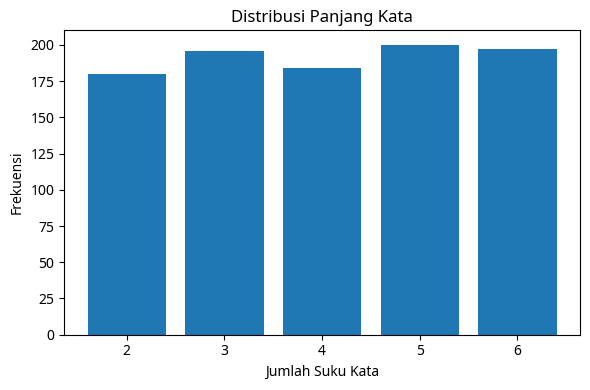

DISTRIBUSI AKSARA
  ꦲ (ha ) |    204 |   5.06%
  ꦤ (na ) |    203 |   5.03%
  ꦕ (ca ) |    202 |   5.01%
  ꦫ (ra ) |    187 |   4.64%
  ꦏ (ka ) |    191 |   4.74%
  ꦢ (da ) |    208 |   5.16%
  ꦠ (ta ) |    214 |   5.31%
  ꦱ (sa ) |    197 |   4.88%
  ꦮ (wa ) |    200 |   4.96%
  ꦭ (la ) |    214 |   5.31%
  ꦥ (pa ) |    206 |   5.11%
  ꦝ (dha) |    206 |   5.11%
  ꦗ (ja ) |    198 |   4.91%
  ꦪ (ya ) |    194 |   4.81%
  ꦚ (nya) |    205 |   5.08%
  ꦩ (ma ) |    202 |   5.01%
  ꦒ (ga ) |    213 |   5.28%
  ꦧ (ba ) |    196 |   4.86%
  ꦛ (tha) |    200 |   4.96%
  ꦔ (nga) |    193 |   4.79%

Total aksara: 4033


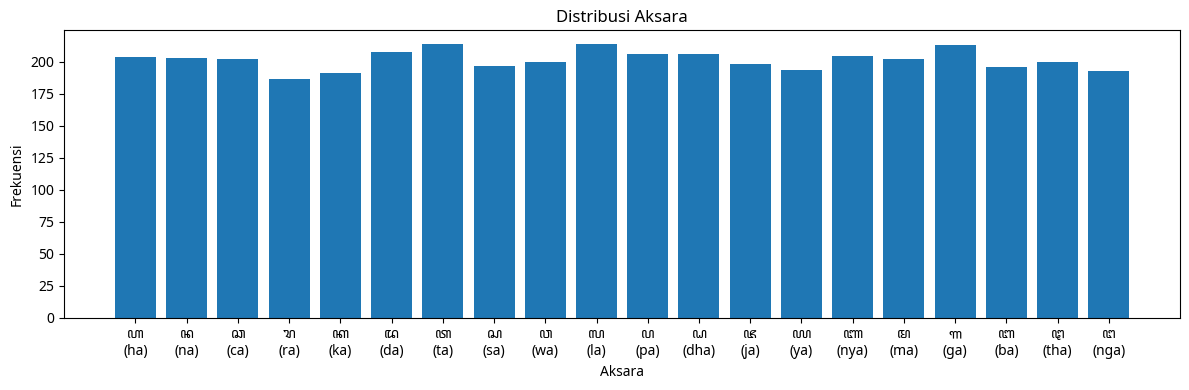

In [5]:
def plot_bar(x, y, title, xlabel, ylabel, figsize):
    plt.figure(figsize=figsize)
    plt.bar(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()



df = pd.read_csv(CSV_PATH)

# DATA SUMMARY
print("=" * 40)
print("RINGKASAN DATA")
print("=" * 40)

print(
    f"Total kata            : {len(df)}\n"
    f"Min panjang kata      : {df['length'].min()}\n"
    f"Max panjang kata      : {df['length'].max()}\n"
    f"Rata-rata panjang     : {df['length'].mean():.2f}\n"
)


# WORD LENGTH DISTRIBUTION
print("=" * 40)
print("DISTRIBUSI PANJANG KATA")
print("=" * 40)

length_dist = df["length"].value_counts().sort_index()
total_words = len(df)

for length, count in length_dist.items():
    pct = count / total_words * 100
    print(f"{length:>2} aksara | {count:5d} kata | {pct:6.2f}%")

plot_bar(
    length_dist.index,
    length_dist.values,
    "Distribusi Panjang Kata",
    "Jumlah Suku Kata",
    "Frekuensi",
    (6, 4),
)


# AKSARA DISTRIBUTION
print("=" * 40)
print("DISTRIBUSI AKSARA")
print("=" * 40)

latin_map = {aks: lat for aks, lat in NGLEGENA}
aksara_dist = pd.DataFrame(
    [(aks, coverage["aksara"][aks]) for aks, _ in NGLEGENA],
    columns=["aksara", "count"],
).assign(
    latin=lambda df: df["aksara"].map(latin_map)
)

total_aksara = aksara_dist["count"].sum()
for _, row in aksara_dist.iterrows():
    pct = (row["count"] / total_aksara * 100) if total_aksara else 0
    print(
        f"{row['aksara']:>3} ({row['latin']:<3}) | "
        f"{row['count']:6d} | {pct:6.2f}%"
    )

print(f"\nTotal aksara: {total_aksara}")
plot_bar(
    [f"{a}\n({latin_map[a]})" for a in aksara_dist["aksara"]],
    aksara_dist["count"],
    "Distribusi Aksara",
    "Aksara",
    "Frekuensi",
    (12, 4),
)
